In [67]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import geopandas as gpd

import rasterio
from rasterio.features import rasterize
from rasterio.plot import reshape_as_image

import folium
from folium.plugins import HeatMap
from folium.raster_layers import WmsTileLayer, ImageOverlay

import matplotlib.pyplot as plt
from PIL import Image
import tempfile

from tqdm import tqdm
from utils import vector_to_heatmap_overlay

In [68]:
GEOSERVER_URL = "https://sparcal.sdsc.edu/geoserver/rrk_sn/wms?"

# directory information for local data
DATA_DIR = "data/"
UTILS_DIR = "utils/"
SN_DIR = DATA_DIR + "sierra_nevada/"

IGNITION_PATH = SN_DIR + "sierra_nevada_fire_ignitions.geojson"
PERIMETER_PATH = SN_DIR + "sierra_nevada_fire_perimeters.geojson"
UTILITY_PATH = SN_DIR + "sierra_nevada_utility_lines.geojson"

SN_SHAPE_PATH = UTILS_DIR + "sierra_nevada_boundary.geojson"
SN_SHAPE = gpd.read_file(SN_SHAPE_PATH).to_crs(epsg=4326).loc[0, 'geometry']

# Fire/Utility Data


In [69]:
ignition_df = gpd.read_file(IGNITION_PATH).to_crs(epsg=4326)
perimeter_df = gpd.read_file(PERIMETER_PATH).to_crs(epsg=4326)
utility_df = gpd.read_file(UTILITY_PATH).to_crs(epsg=4326)
buffered_ignition = gpd.read_file(IGNITION_PATH).buffer(500).to_crs(epsg=4326)

In [85]:
# utility lines
utility_layer = folium.GeoJson(utility_df, name="Transmission Lines")

# Folium Heatmap (unused but here's the code)
"""
ignition_df['LATITUDE'] = ignition_df.geometry.y
ignition_df['LONGITUDE'] = ignition_df.geometry.x
ignition_coords = ignition_df[['LATITUDE', 'LONGITUDE']].values.tolist()
ignition_heatmap_layer = HeatMap(ignition_coords, name="Ignition Points")
"""

# Heatmaps with Vector To Heatmap Overlay Function
perimeter_heatmap = vector_to_heatmap_overlay(perimeter_df['geometry'], "Fire Perimeters", SN_SHAPE)
ignition_heatmap = vector_to_heatmap_overlay(buffered_ignition, "Fire Ignition Points", SN_SHAPE)

# save all to list
fire_utility_layers = [utility_layer, perimeter_heatmap, ignition_heatmap]

100%|██████████| 4043/4043 [00:22<00:00, 178.75it/s]


In [51]:
# save all to list
fire_utility_layers = [utility_layer, perimeter_heatmap, ignition_heatmap]

# Geoserver Layers
RRK link: https://rrk.sdsc.edu/sierra.html

Geoserver Link: https://sparcal.sdsc.edu/geoserver/web/wicket/bookmarkable/org.geoserver.web.demo.MapPreviewPage?0&filter=false

In [81]:
carbon_layers = []
carbon_layer_info = {'Dead Carbon':'rrk_sn:DeadCarbon_2021',
                     'Total Carbon':'rrk_sn:CECS_TotalCarbon_30m',
                     'Aboveground Live Tree Carbon':'rrk_sn:F3_AbovegroundLiveTreeCarbon_2021',
                     'Total Aboveground Carbon':'rrk_sn:CECS_TotalCarbon_30m'}
for layer_name in carbon_layer_info:
    layer = WmsTileLayer(url=GEOSERVER_URL,
                         layers=carbon_layer_info[layer_name],
                         name=layer_name,
                         transparent=True,
                         overlay=True,
                         control=True,
                         fmt="image/png8",
                         tiled=True,
                         opacity=0.5)
    carbon_layers.append(layer)

# The Map


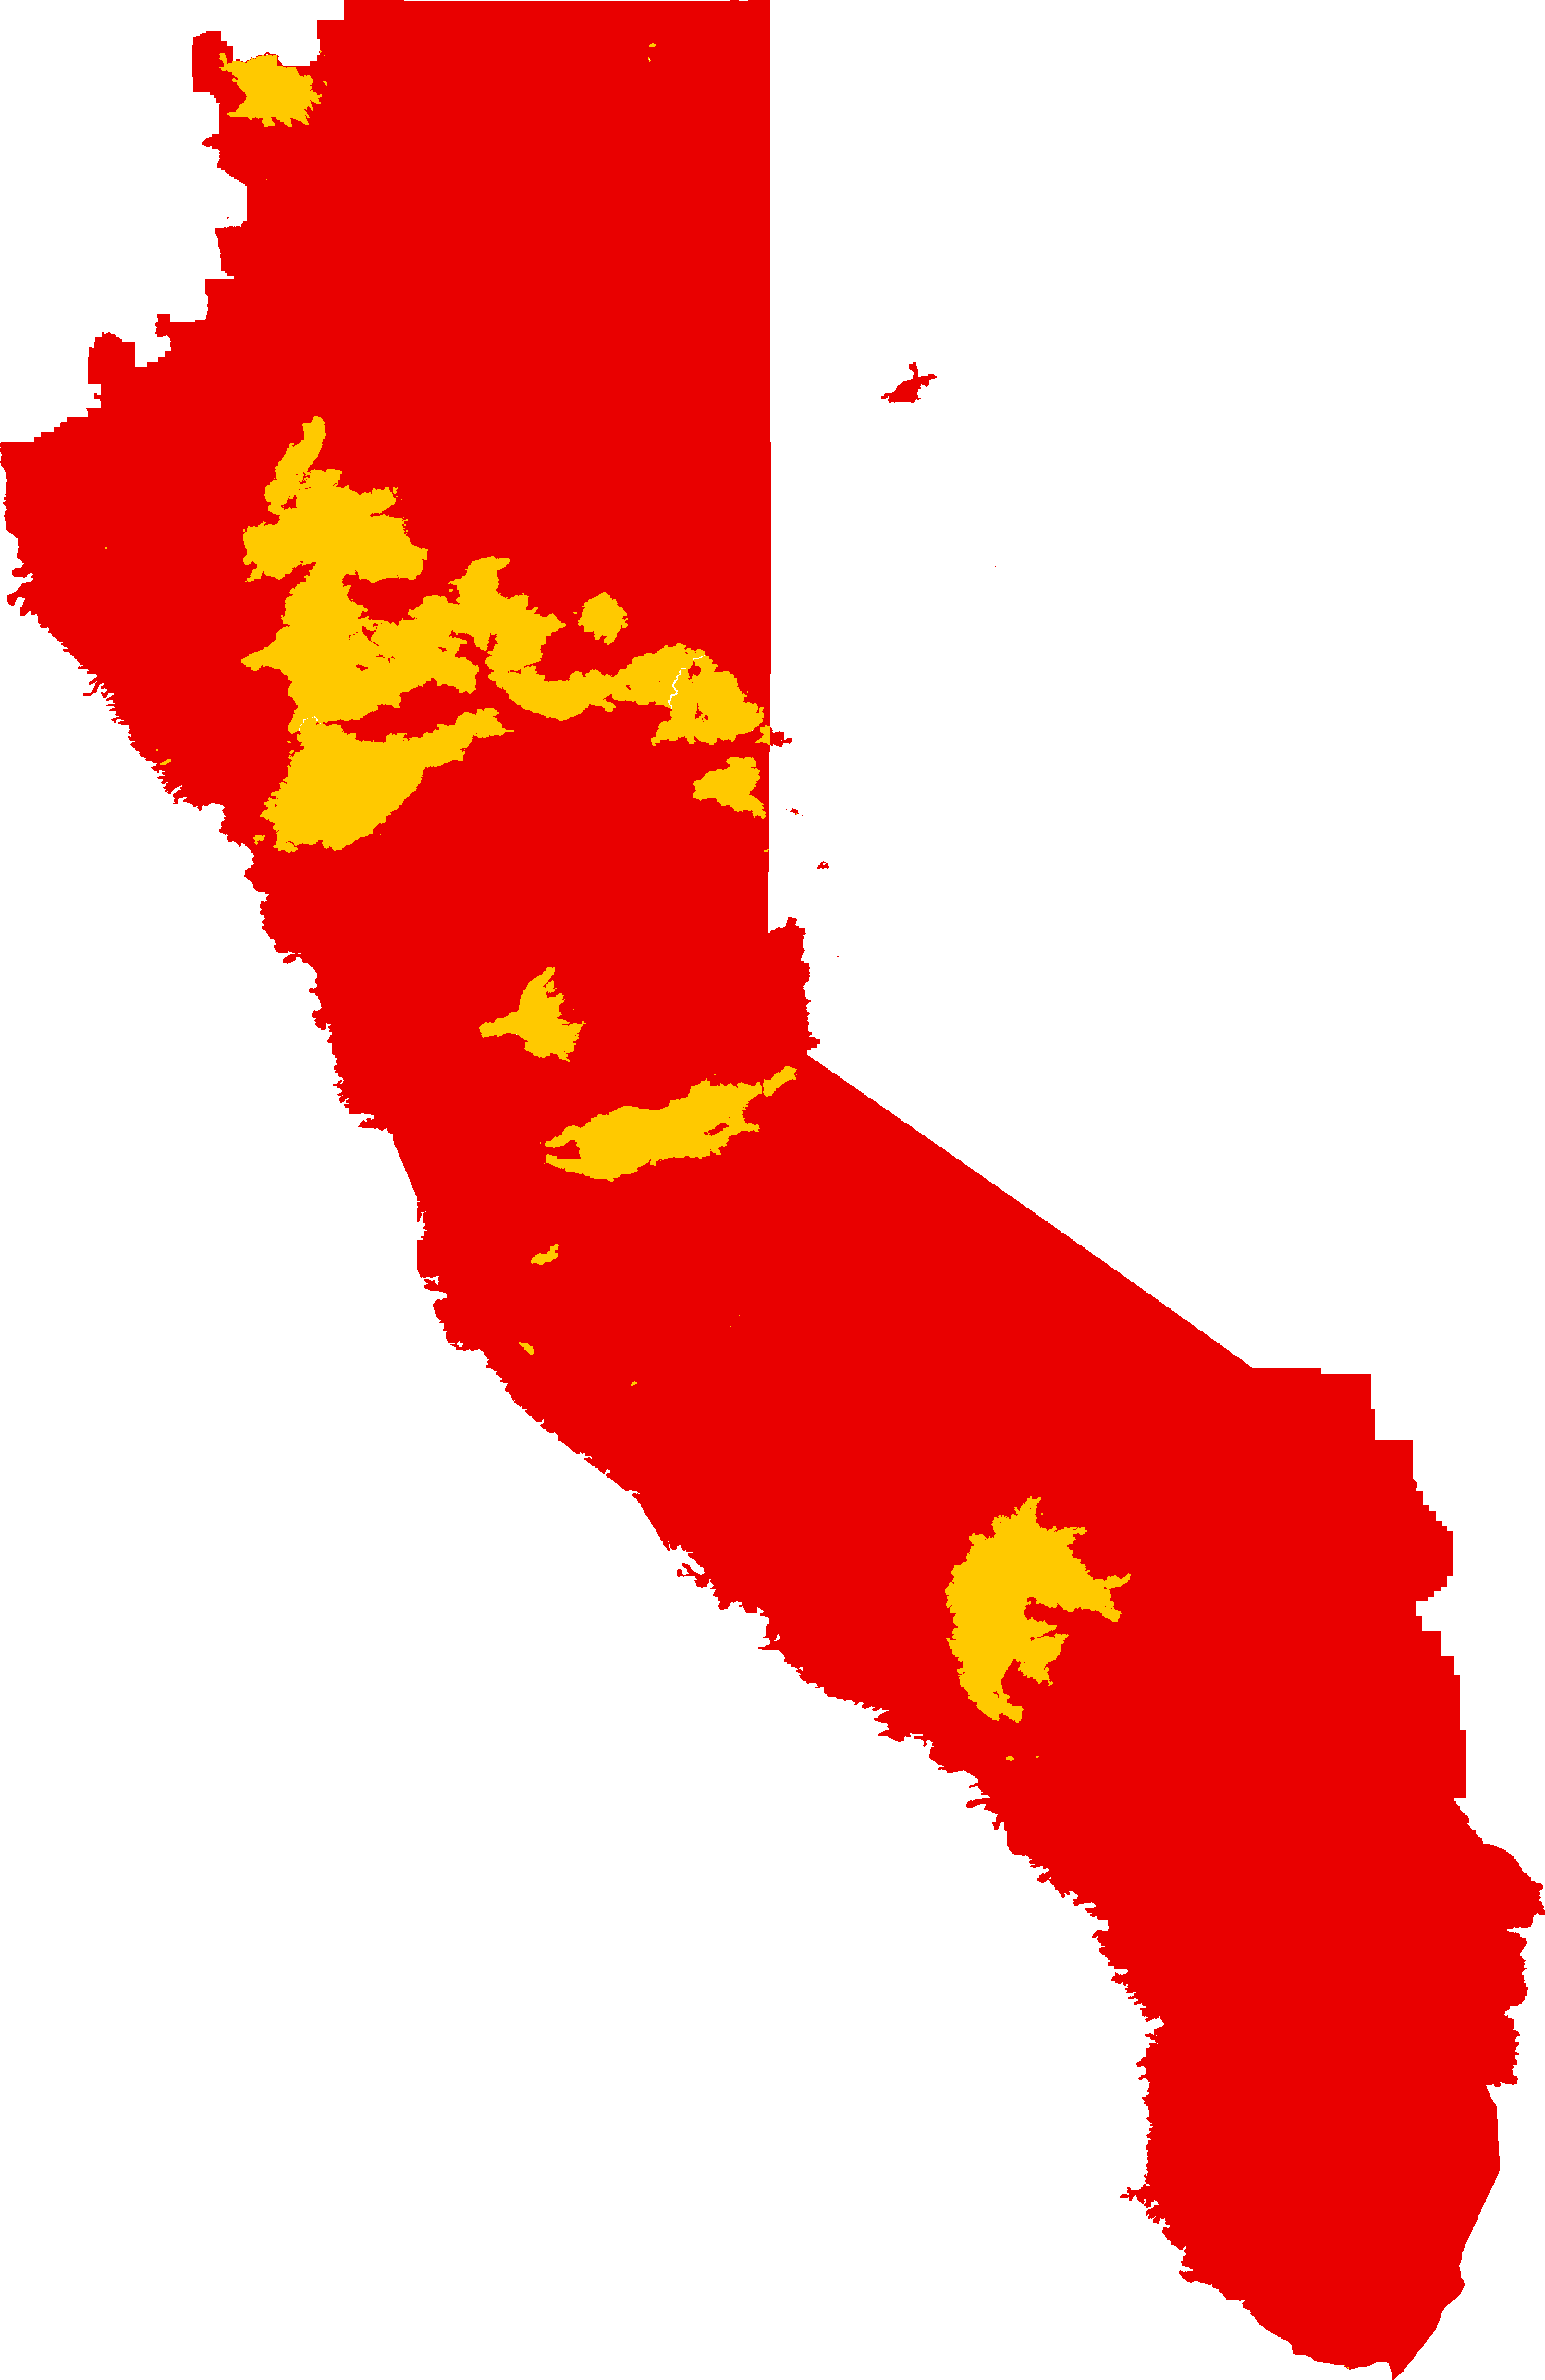
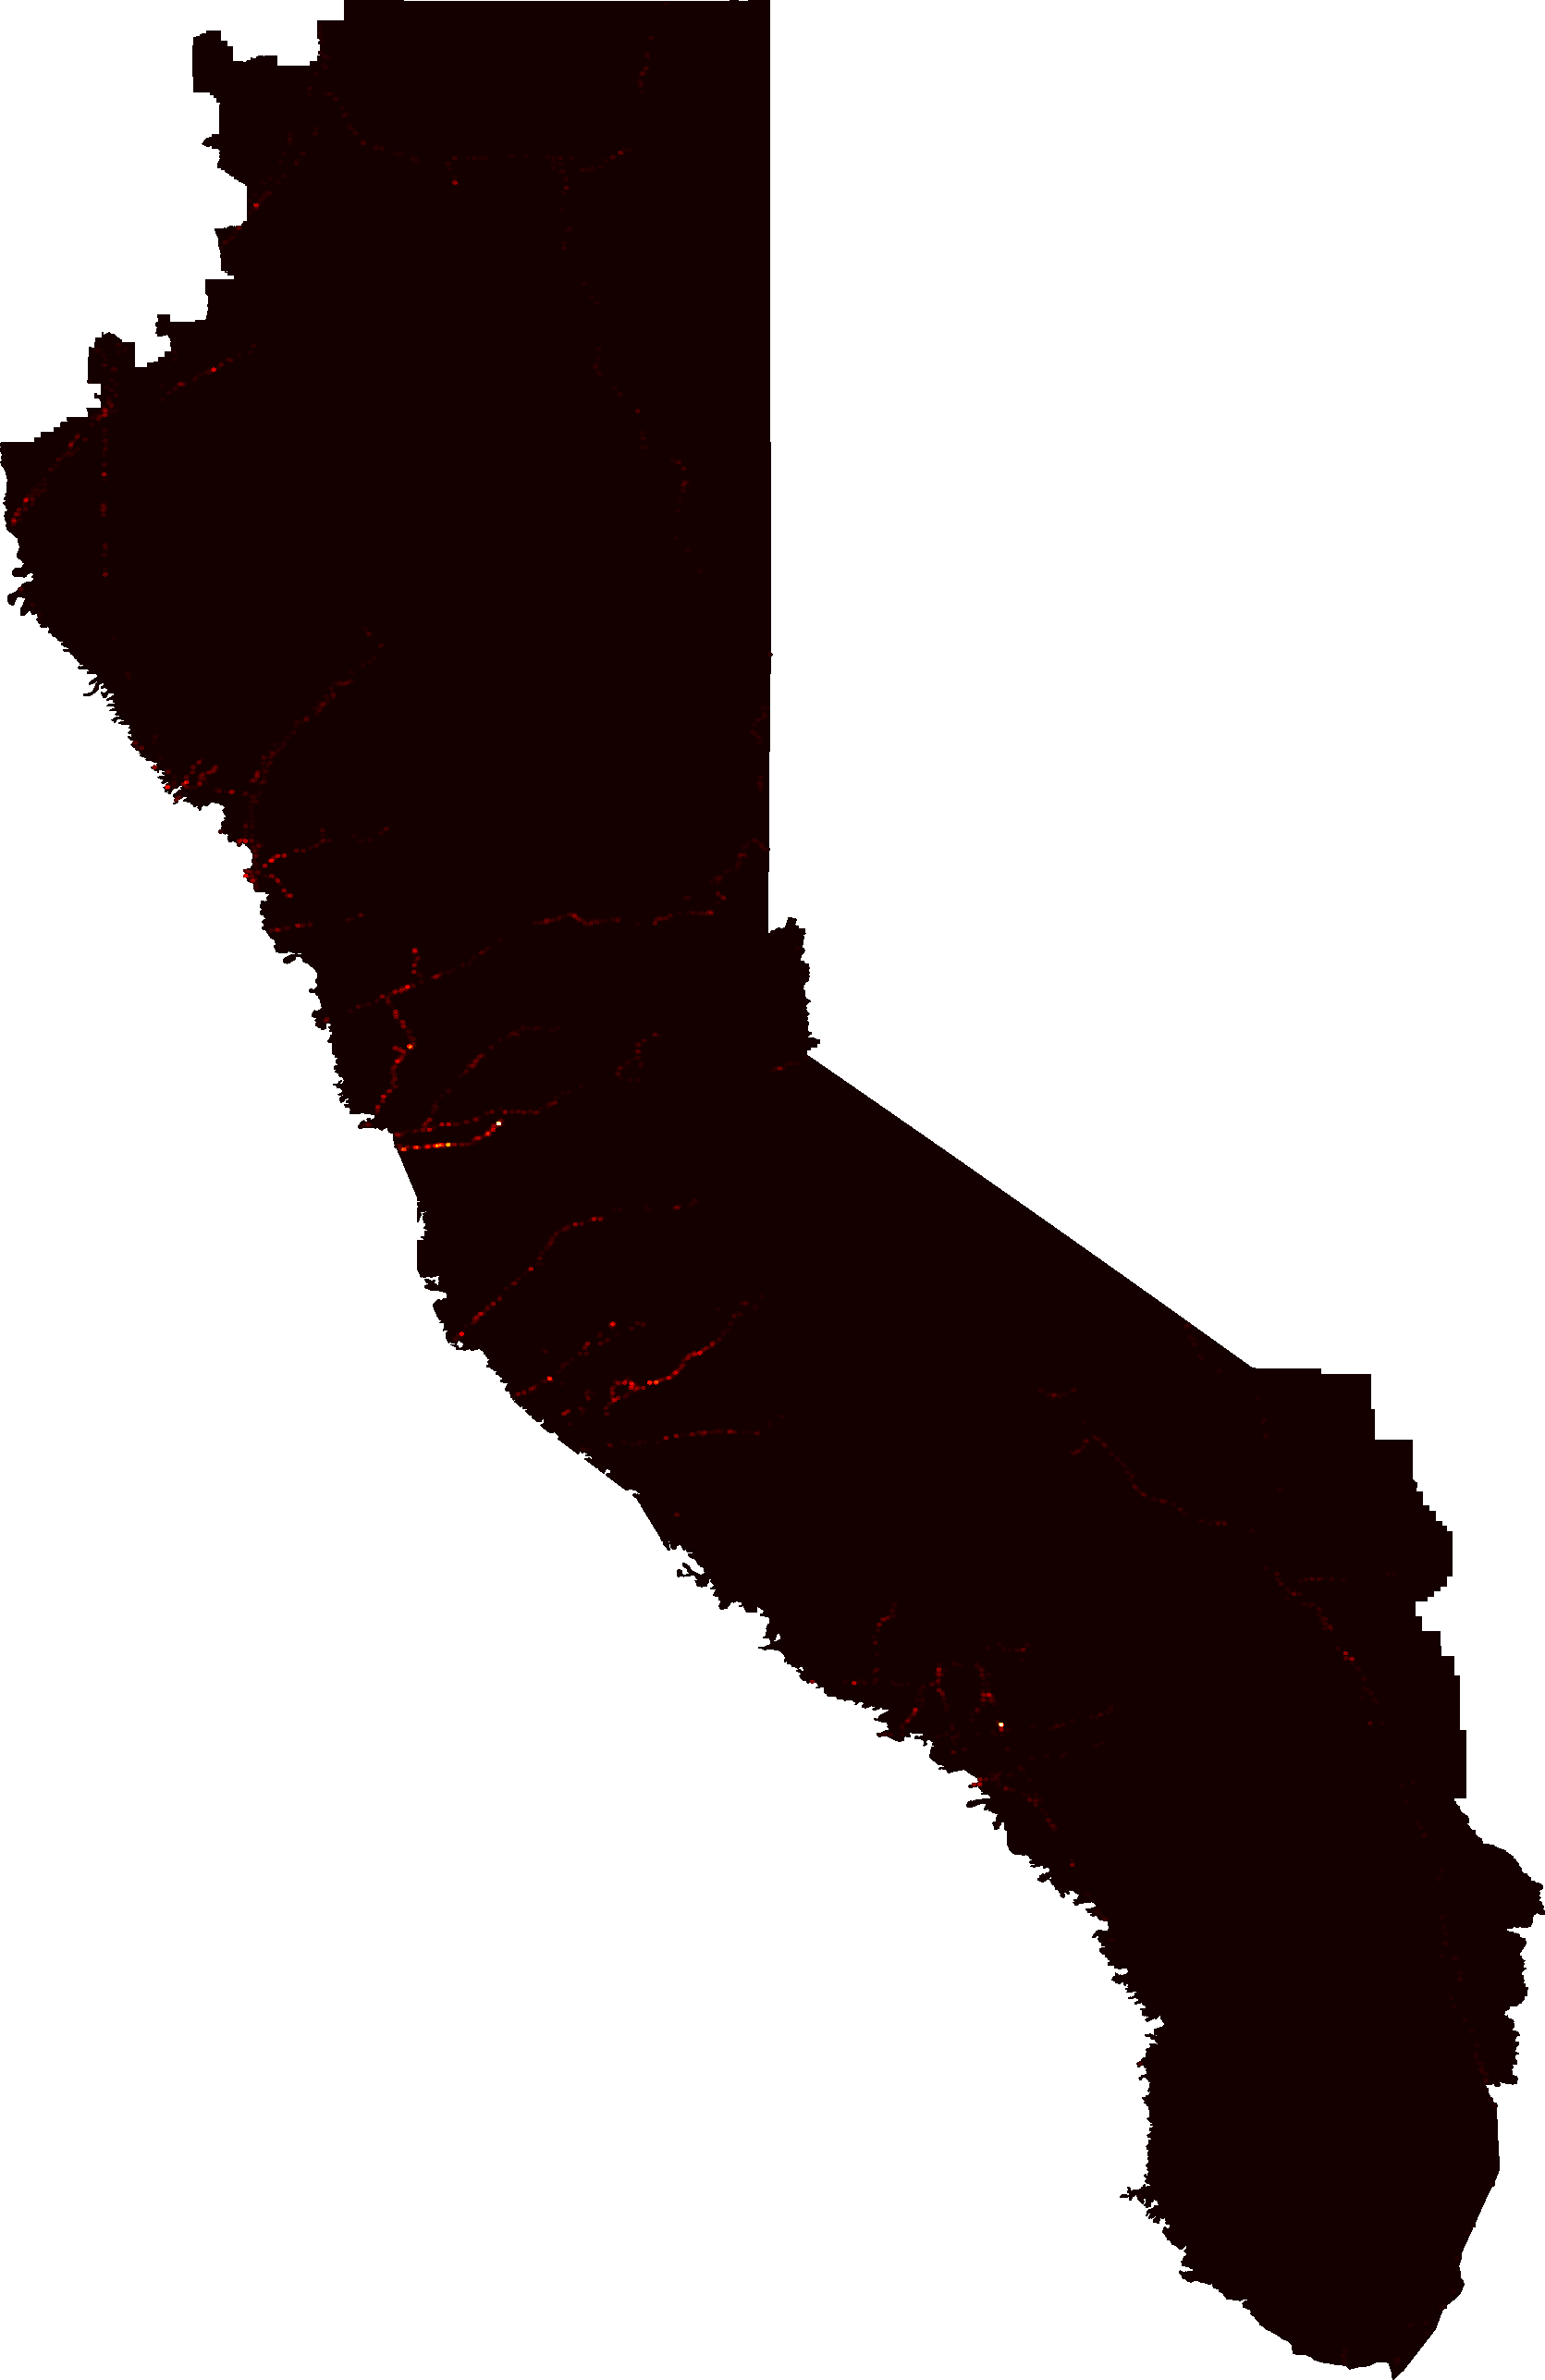

In [91]:
center = SN_SHAPE.centroid
map_center = [center.y, center.x]
m = folium.Map(location=map_center, tiles="CartoDB Positron", zoom_start=8)

layers = carbon_layers + fire_utility_layers

for layer in layers:
    layer.add_to(m)

folium.GeoJson(SN_SHAPE, name="Sierra Nevada Region").add_to(m)
folium.LayerControl().add_to(m)
m

# I'm Experimenting here:

In [84]:
METERS_PER_DEG_LAT = 11111.11
METERS_PER_DEG_LON = 11139

def vector_to_heatmap_overlay(geoms, layer_name, aoi_geom=SN_SHAPE, cmap_name='hot', pixel_size=30):
    ##TODO: adjust sampling resolution
    minx, miny, maxx, maxy = aoi_geom.bounds
    width_raw = maxx - minx
    height_raw = maxy - miny
    width_adj = int(width_raw * METERS_PER_DEG_LAT / pixel_size)
    height_adj = int(height_raw * METERS_PER_DEG_LON / pixel_size)
    trans = rasterio.transform.from_bounds(minx, miny, maxx, maxy, width_adj, height_adj)
    data = np.zeros((height_adj, width_adj))
    

    # get overlaps
    for geom in tqdm(geoms):
        rasterized_geom = rasterize(shapes=[(geom, 1)], fill=0, transform=trans, out_shape=(height_adj, width_adj), all_touched=True)
        data += rasterized_geom
    data += rasterize(shapes=[(aoi_geom, 1)], fill=0, transform=trans, out_shape=(height_adj, width_adj), all_touched=True)
    # create image
    cmap = plt.get_cmap(cmap_name)
    norm = plt.Normalize(vmin=data.min(), vmax=data.max())
    image_data = cmap(norm(data))
    alpha_channel = np.where(data > 0, 255, 0)
    rgba_image_data = np.dstack((image_data[:, :, :3] * 255, alpha_channel)).astype(np.uint8)
    image = Image.fromarray(rgba_image_data, 'RGBA')
    with tempfile.NamedTemporaryFile(delete=False, suffix='.png') as tmp_file:
        image.save(tmp_file.name, format='PNG')
        tmp_file_path = tmp_file.name
    # create layer
    img_overlay = ImageOverlay(
        name=layer_name,
        image=tmp_file_path,
        bounds=[[miny, minx], [maxy, maxx]],
        opacity=0.6,
        transparent=True,
        overlay=True,
        control=True,
        fmt="image/png8",
        tiled=True,
    )
    return img_overlay